In [1]:
%load_ext autoreload
%autoreload 2

In [172]:
import numpy as np
import sys
import pandas as pd
import os
sys.path.append("../")
import utils.common
import seaborn as sns
import matplotlib.pyplot as plt
import logging
from utils.common import get_trial_paths, get_trial_df, get_initial_state_df, get_prey_pos_df, display_prey_agent_pos, get_agent_pos_df, get_occluders_pos_df

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logger.info('DEBUG')

In [309]:
human_base_path = '../../logs/exp_pong_single_ball/0'
trial_paths = get_trial_paths(human_base_path)
trial_df = get_trial_df(trial_paths)
trial_df = (trial_df.pipe(get_initial_state_df)
    .pipe(utils.common.get_condition_df)
    .drop('initial_state', axis='columns')    
    .pipe(get_prey_pos_df)
    .pipe(get_agent_pos_df)
    .pipe(get_occluders_pos_df)    
    .assign(trial_end_step=utils.common.get_trial_end_step)
    .pipe(utils.common.trim_pos, 'agent_pos')
    .pipe(utils.common.trim_pos, 'prey_pos')
    .pipe(utils.common.trim_pos, 'occluders_pos')    
    .assign(success=utils.common.get_success,)
    .assign(
        prey_visible=utils.common.get_prey_visible,     
        prey_visible_step=utils.common.get_prey_visible_step, 
        error=utils.common.get_error)        
    .set_index(['prey_vel', 'prey_x', 'occluded'])
    .sort_index()
)
trial_df.head()


trial_num  \
prey_vel prey_x occluded              
-0.01    0.1    False            12   
                False            24   
                False           108   
                False           191   
                True             45   

                                                                 trial_path  \
prey_vel prey_x occluded                                                      
-0.01    0.1    False     ../../logs/exp_pong_single_ball/0/2021_11_19_1...   
                False     ../../logs/exp_pong_single_ball/0/2021_11_19_1...   
                False     ../../logs/exp_pong_single_ball/0/2021_11_19_1...   
                False     ../../logs/exp_pong_single_ball/0/2021_11_19_1...   
                True      ../../logs/exp_pong_single_ball/0/2021_11_19_1...   

                                                                   prey_pos  \
prey_vel prey_x occluded                                                      
-0.01    0.1    False     [[0.09864449098752676, 1.16], [0.1086444909875...   
                False     [[0.09864449098752676, 1.16], [0.1086444909875...   
                False     [[0.09864449098752676, 1.16], [0.1086444909875...   
                False     [[0.09864449098752676, 1.16], [0.1086444909875...   
                True      [[0.09864449098752676, 1.16], [0.1086444909875...   

                                                                  agent_pos  \
prey_vel prey_x occluded                                                      
-0.01    0.1    False     [[0.5, 0.09999999999999998], [0.5, 0.099999999...   
                False     [[0.5261694343597967, 0.09999999999999998], [0...   
                False     [[0.5, 0.09999999999999998], [0.51308471717989...   
                False     [[0.5, 0.09999999999999998], [0.5, 0.099999999...   
                True      [[0.4738305656402033, 0.09999999999999998], [0...   

                                                              occluders_pos  \
prey_vel prey_x occluded                                                      
-0.01    0.1    False     [[-0.3750000000000001, 0.5, 1.3750000000000002...   
                False     [[-0.3488305656402034, 0.5, 1.4011694343597971...   
                False     [[-0.3750000000000001, 0.5, 1.3750000000000002...   
                False     [[-0.3750000000000001, 0.5, 1.3750000000000002...   
                True      [[-0.4011694343597968, 0.5, 1.3488305656402033...   

                          trial_end_step  success  \
prey_vel prey_x occluded                            
-0.01    0.1    False                 51        1   
                False                 51        1   
                False                 51        1   
                False                 51        1   
                True                  51        1   

                                                               prey_visible  \
prey_vel prey_x occluded                                                      
-0.01    0.1    False     [False, False, False, False, False, False, Fal...   
                False     [False, False, False, False, False, False, Fal...   
                False     [False, False, False, False, False, False, Fal...   
                False     [False, False, False, False, False, False, Fal...   
                True      [False, False, False, False, False, False, Tru...   

                          prey_visible_step     error  
prey_vel prey_x occluded                               
-0.01    0.1    False                    15  0.001126  
                False                    20  0.034039  
                False                    41  0.032203  
                False                     8  0.032199  
                True                      6  0.032203

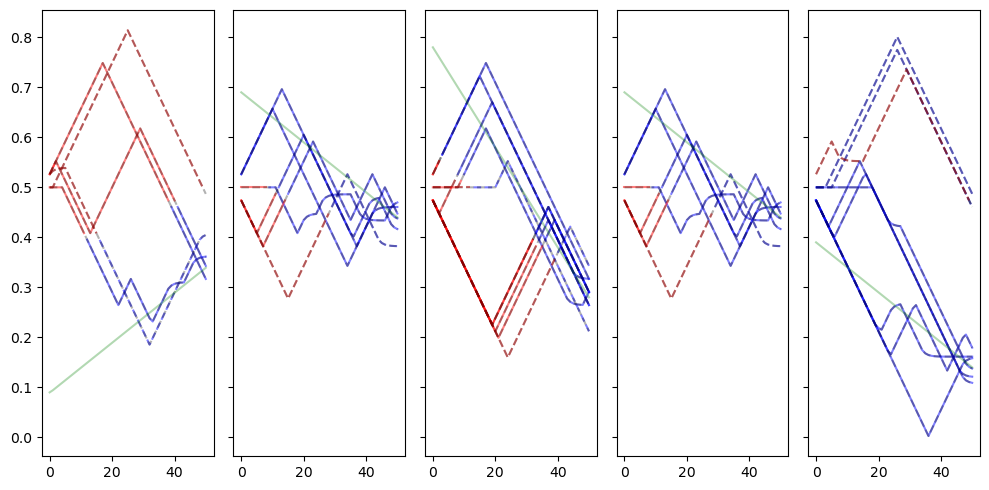

In [337]:
n_conditions = 5
conditions = np.random.choice(trial_df.loc[pd.IndexSlice[:, :, True], :].index, n_conditions)
f, axs = plt.subplots(1, n_conditions, figsize=(10, 5), dpi=100, sharey=True)
for i_c, condition in enumerate(conditions):
    trials = trial_df.loc[condition]
    agent_pos = trials.agent_pos.to_numpy()
    trial_end_step = trials.trial_end_step.to_numpy()
    success = trials.success.to_numpy()
    prey_pos = trials.prey_pos.to_numpy()
    visibility_step = trials.prey_visible_step.to_numpy()
    n_trials = len(trials)
    
    for i, (ap, vs, s, pp) in enumerate(list(zip(agent_pos, visibility_step, success, prey_pos))):
        ap = np.asarray(ap).squeeze()[:, 0]
        pp = np.asarray(pp).squeeze()[:, 0]
        vap = ap[vs:] if vs != -1 else []
        oap = ap[:vs]
        ot = np.arange(vs) if vs != -1 else np.arange(len(ap)-1)        
        vt = np.arange(start=vs, stop=len(ap), step=1) if vs != -1 else []        
        linestyle = '-' if s else '--'                
        color = 'b' if s else 'r'
        axs[i_c].plot(ot, oap, color='r', linestyle=linestyle, alpha=0.5)    
        axs[i_c].plot(vt, vap, color='b', linestyle=linestyle, alpha=0.5)
        axs[i_c].plot(np.arange(len(ap)), ap, linestyle='--', alpha=0.3, color='k')
    axs[i_c].plot(np.arange(len(ap)), pp,  alpha=0.3, color='g')    
plt.tight_layout()
plt.show()

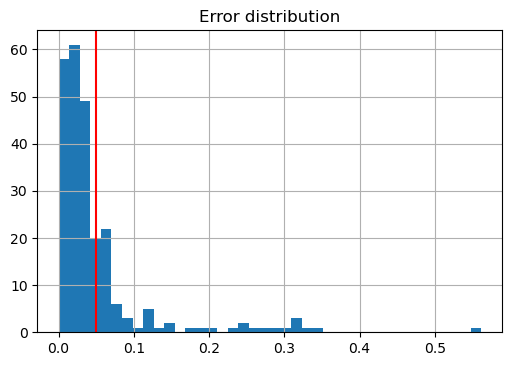

In [336]:
f, ax = plt.subplots(1, 1, dpi=100)
trial_df.error.hist(ax=ax, bins=40)
ax.axvline(0.05, c='r')
ax.set_title('Error distribution')
plt.show()